In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)

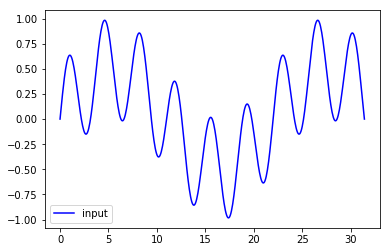

In [2]:
steps = np.linspace(0, np.pi*10, 500, dtype=np.float32)
x_np = np.cos(steps / 1.4) * np.sin(steps)
plt.plot(steps, x_np, 'b-', label='input')
plt.legend(loc='best')
plt.show()

# Autoregrssive modeling with RNNs

## RNN
Recurrent Neural Networks model sequential data as
## \begin{align}
&h_t = tanh(W_x x + W_h h_{t-1} + b_h) \\
&y_t = W_y h_t + b_y
\end{align}

<img src=images/rnn.png width="200">

<img src=images/rnn_unfolded.png width="700">


## Autoregressive model
## \begin{align}
p(x_1, x_2, ..., x_T) 
&= p(x_1) p(x_2 | x_1) p(x_3 | x_1, x_2) ... p(x_T | x_1, ..., x_{T-1}) \\
&= \prod_{t=1}^T p(x_t|x_1, ..., x_{t-1})
\end{align}



## Using RNNs for autoregressive modeling
Define $y_t$ as prediction of next step: $y_t = \hat{x}_{t+1}$

## \begin{align}
h_{t}, \hat{x}_{t+1} = RNN(x_{t}, h_{t-1})
\end{align}

Minimize Mean Squared Error (MSE) :
## \begin{align}
\frac{1}{T-1} \sum_{t=2}^T |\hat{x}_t  - x_t|^2
\end{align}

# Implement RNN

In [ ]:
# Implement below
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Define layers
        # ------------

    def forward(self, x, h_state=None):
        # x (batch_size, input_size)
        # h_state (batch, hidden_size)
        # out (batch, output_size)
        
        if h_state is None:
            h_state = torch.zeros(x.size()[0], self.hidden_size)
            
        # Define computation
        # ------------------

        return h_state, prediction

In [4]:
# Implement below
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Define layers
        # ------------
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_state=None):
        # x (batch_size, input_size)
        # h_state (batch, hidden_size)
        # prediction (batch, output_size)
        
        if h_state is None:
            h_state = torch.zeros(x.size()[0], self.hidden_size)

        # Define computation
        # ------------------
        h_state = torch.tanh(self.linear1(x) + self.linear2(h_state))
        prediction = self.out(h_state)
    
        return h_state, prediction

# Train the model

RNN(
  (linear1): Linear(in_features=1, out_features=10, bias=False)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)


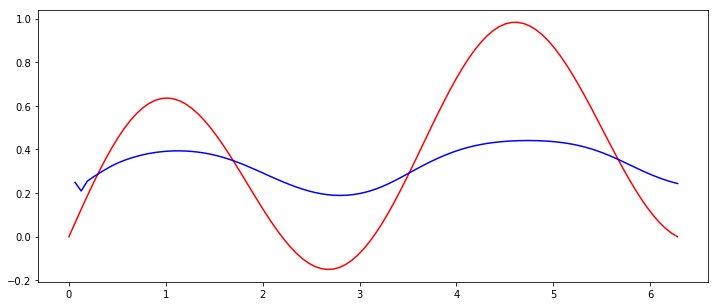

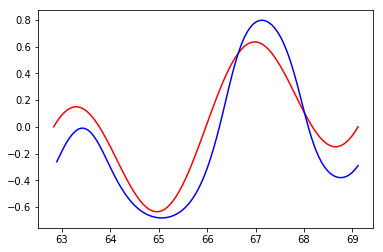

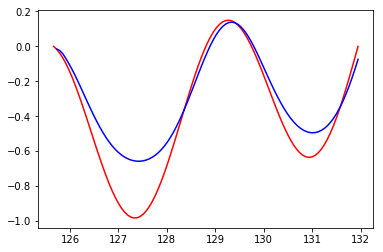

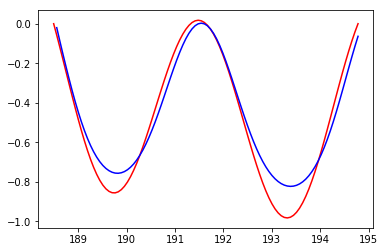

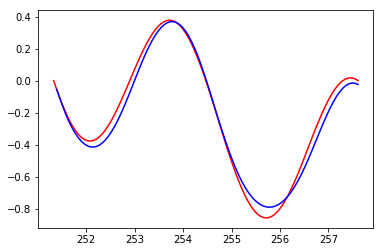

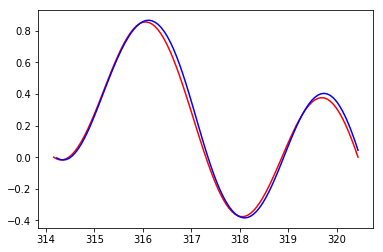

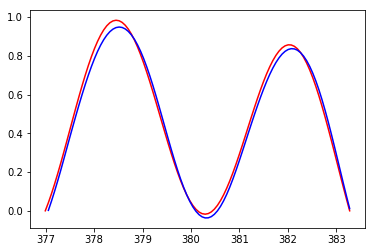

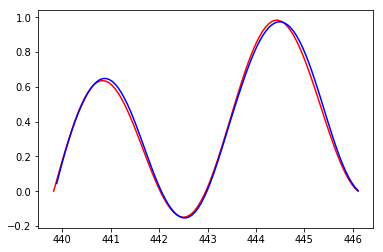

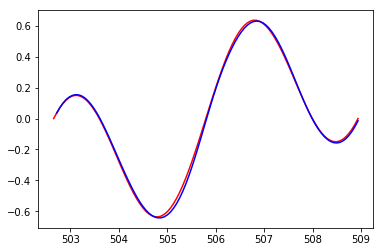

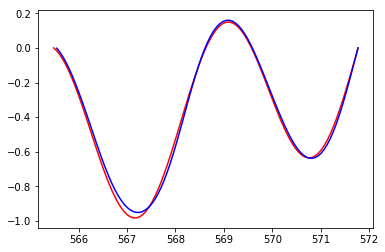

In [8]:
model = RNN(input_size=1, hidden_size=10, output_size=1)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # optimize all cnn parameters
loss_function = nn.MSELoss()

h_state = None      # for initial hidden state

plt.figure(1, figsize=(12, 5))
plt.ion()           # continuously plot

for step in range(100):
    start, end = step * 2.0 * np.pi, (step+1)* 2.0 * np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, 100, dtype=np.float32)
    x_np = np.cos(steps / 1.4) * np.sin(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    
    loss = 0.0
    predictions = []

    for i in range(x.size(1) - 1):
        h_state, prediction = model(x[:, i, :], h_state)
        predictions.append(prediction.item())
        loss += loss_function(prediction, x[:, i+1, :])         # calculate loss

    # !! next step is important !!
    h_state = h_state.data        # repack the hidden state, break the connection from last iteration

    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    if step % 10 == 0:
        plt.plot(steps, x_np.flatten(), 'r-', label='data')
        plt.plot(steps[1:], predictions, 'b-', label='prediction')
        plt.draw(); plt.pause(0.05)

plt.show()
plt.ioff()

## LSTMs

<img src=images/lstm_chain.png width="700">

## \begin{align}
i_t &= \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
            f_t &= \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
            g_t &= \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
            o_t &= \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
            c_t &= f_t c_{(t-1)} + i_t g_t \\
            h_t &= o_t \tanh(c_t)
\end{align}

## $i_t$: input gate
## $f_t$: forget gate
## $g_t$: cell input
## $c_t$: cell state
## $h_t$: hidden state
## $o_t$: output_gate

# Implement LSTMs
## Prediction: $y_t = W_o o_t + b_o$

In [9]:
# Implement below
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Define layers
        # ------------
        self.linear_ii = nn.Linear(input_size, hidden_size) 
        self.linear_if = nn.Linear(input_size, hidden_size) 
        self.linear_ig = nn.Linear(input_size, hidden_size) 
        self.linear_io = nn.Linear(input_size, hidden_size) 
        
        self.linear_hi = nn.Linear(hidden_size, hidden_size) 
        self.linear_hf = nn.Linear(hidden_size, hidden_size) 
        self.linear_hg = nn.Linear(hidden_size, hidden_size) 
        self.linear_ho = nn.Linear(hidden_size, hidden_size) 
        
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, c_state=None, h_state=None):
        # x (batch_size, input_size)
        # h_state (batch, hidden_size)
        # out (batch, output_size)
        
        if h_state is None:
            h_state = torch.zeros(x.size()[0], self.hidden_size)
         
        if c_state is None:
            c_state = torch.zeros(x.size()[0], self.hidden_size)
            
        # Define computation
        # ------------------
        input_gate = torch.sigmoid(self.linear_ii(x) + self.linear_hi(h_state))
        forget_gate = torch.sigmoid(self.linear_if(x) + self.linear_hf(h_state))
        c_input = torch.tanh(self.linear_ig(x) + self.linear_hg(h_state))
        output_gate = torch.sigmoid(self.linear_io(x) + self.linear_ho(h_state))
        c_state = forget_gate * c_state + input_gate * c_input
        h_state = output_gate * torch.tanh(c_state)
        prediction = self.out(h_state)
        
        return c_state, h_state, prediction

LSTM(
  (linear_ii): Linear(in_features=1, out_features=10, bias=True)
  (linear_if): Linear(in_features=1, out_features=10, bias=True)
  (linear_ig): Linear(in_features=1, out_features=10, bias=True)
  (linear_io): Linear(in_features=1, out_features=10, bias=True)
  (linear_hi): Linear(in_features=10, out_features=10, bias=True)
  (linear_hf): Linear(in_features=10, out_features=10, bias=True)
  (linear_hg): Linear(in_features=10, out_features=10, bias=True)
  (linear_ho): Linear(in_features=10, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)


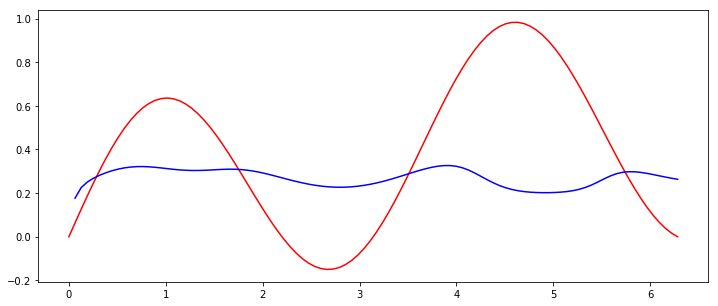

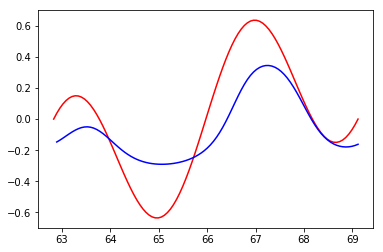

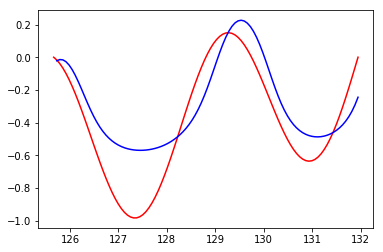

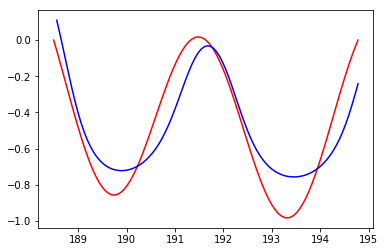

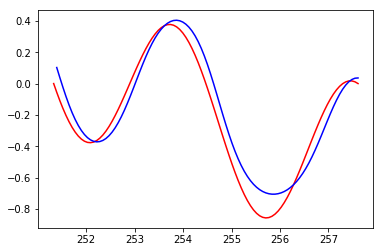

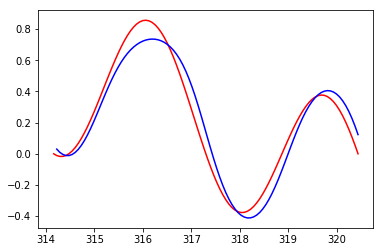

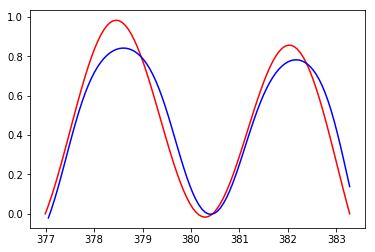

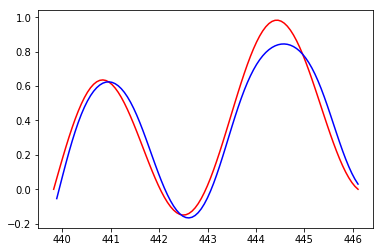

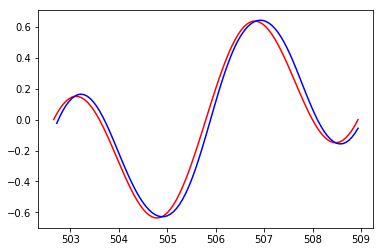

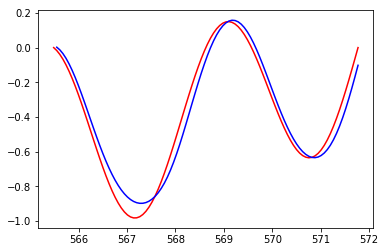

In [11]:
model = LSTM(input_size=1, hidden_size=10, output_size=1)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # optimize all cnn parameters
loss_function = nn.MSELoss()

h_state = c_state = None      # for initial hidden state

plt.figure(1, figsize=(12, 5))
plt.ion()           # continuously plot

for step in range(100):
    start, end = step * 2.0 * np.pi, (step+1)* 2.0 * np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, 100, dtype=np.float32)
    x_np = np.cos(steps / 1.4) * np.sin(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    
    loss = 0.0
    predictions = []

    for i in range(x.size(1) - 1):
        c_state, h_state, prediction = model(x[:, i, :], c_state, h_state)
        predictions.append(prediction.item())
        loss += loss_function(prediction, x[:, i+1, :])         # calculate loss

    # !! next step is important !!
    h_state = h_state.data        # repack the hidden state, break the connection from last iteration
    c_state = c_state.data

    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    if step % 10 == 0:
        plt.plot(steps, x_np.flatten(), 'r-', label='data')
        plt.plot(steps[1:], predictions, 'b-', label='prediction')
        plt.draw(); plt.pause(0.05)

plt.show()
plt.ioff()